In [234]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Preparing Data

In [235]:
import torch.nn as nn
import torch.nn.functional as F

In [236]:
transform=transforms.Compose([transforms.ToTensor()])

In [237]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [238]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [239]:
data=data.reshape(data.shape[0],-1) 

In [240]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [241]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [242]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [243]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)  

In [244]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# A2 . Logistic Regression 

###  Binary Classification Task


In [245]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [246]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [247]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [248]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [249]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [250]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [251]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]
start = time.time()
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')
end_time = time.time()
logistic_regression_time = end_time-start
print(logistic_regression_time)

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220
8.798422813415527


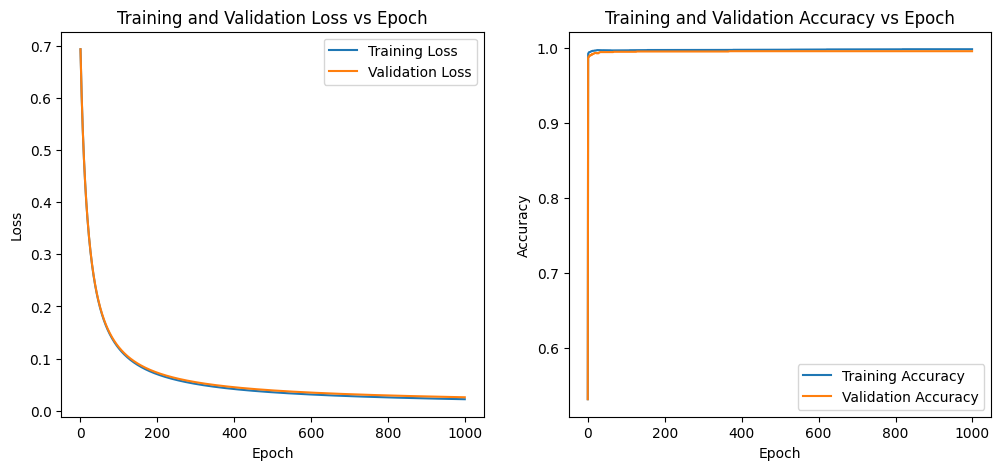

In [252]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [253]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

logistic_regression_acc=test_accuracy.item()*100
print(f'Test Accuracy: {logistic_regression_acc:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [254]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


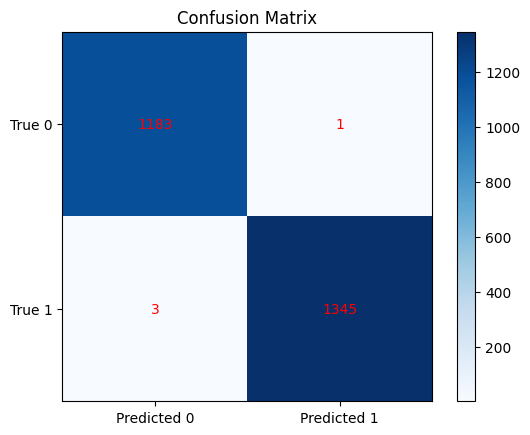

In [255]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()

# A3.Softmax Regression

### Multi-class Classification Task

In [256]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

In [257]:
def cross_entropy_loss(predictions, targets):
    num_samples = predictions.shape[0]
    log_probs = -torch.log(predictions[range(num_samples), targets])
    loss = torch.mean(log_probs)
    return loss

In [258]:
number_of_features=28*28 
number_of_classes=10

W_multi=torch.zeros((number_of_features,number_of_classes),requires_grad=True)
b_multi=torch.zeros((1,number_of_classes),requires_grad=True)

lr=0.01
num_epochs=10

In [260]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]
start= time.time()
for epoch in range(num_epochs):
    total_loss=0
    total_correct=0
    total=0
    for images,labels in training_loader:
        trained_data=images.view(-1,28*28)

        scores=linear_output(trained_data,W_multi,b_multi)
        training_predictions=softmax(scores)

        loss=cross_entropy_loss(training_predictions,labels)
        loss.backward()

        predections=torch.argmax(training_predictions,dim=1)

        total_correct+=(predections==labels).sum().item()
        total+=labels.size(0)
        total_loss+=loss.item()*labels.size(0)

        with torch.no_grad():
            W_multi-=lr*W_multi.grad
            b_multi-=lr*b_multi.grad
        W_multi.grad.zero_()
        b_multi.grad.zero_()


    training_loss=total_loss/total
    training_accuracy=total_correct/total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)


    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        total_val=0
        for val_images,val_labels in validation_loader:
            val_trained_data=val_images.view(-1,28*28)

            val_scores=linear_output(val_trained_data,W_multi,b_multi)
            val_predictions=softmax(val_scores)

            val_loss=cross_entropy_loss(val_predictions,val_labels)

            val_predections=torch.argmax(val_predictions,dim=1)

            total_val_correct+=(val_predections==val_labels).sum().item()
            total_val+=val_labels.size(0)
            total_val_loss+=val_loss.item()*val_labels.size(0)

        validation_loss=total_val_loss/total_val
        validation_accuracy=total_val_correct/total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')
end = time.time()
softmax_time= end-start
print(softmax_time)

Epoch [1/10], Training Loss: 1.1713, Validation Loss: 0.7676
Epoch [2/10], Training Loss: 0.6552, Validation Loss: 0.5941
Epoch [3/10], Training Loss: 0.5443, Validation Loss: 0.5243
Epoch [4/10], Training Loss: 0.4909, Validation Loss: 0.4849
Epoch [5/10], Training Loss: 0.4580, Validation Loss: 0.4592
Epoch [6/10], Training Loss: 0.4354, Validation Loss: 0.4400
Epoch [7/10], Training Loss: 0.4184, Validation Loss: 0.4260
Epoch [8/10], Training Loss: 0.4052, Validation Loss: 0.4144
Epoch [9/10], Training Loss: 0.3945, Validation Loss: 0.4050
Epoch [10/10], Training Loss: 0.3855, Validation Loss: 0.3974
23.090685844421387


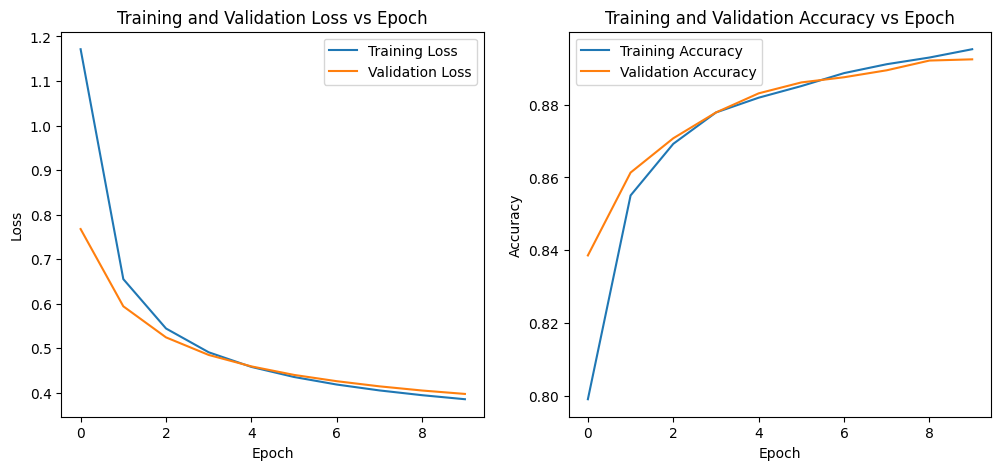

In [261]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

In [262]:
confusion_matrix_multi=torch.zeros(number_of_classes,number_of_classes,dtype=torch.int32)
total_correct=0
total=0
with torch.no_grad():
    for test_images,test_labels in testing_loader:
        test_trained_data=test_images.view(-1,28*28)

        test_scores=linear_output(test_trained_data,W_multi,b_multi)
        test_predictions=softmax(test_scores)

        test_predections=torch.argmax(test_predictions,dim=1)

        total_correct+=(test_predections==test_labels).sum().item()
        total+=test_labels.size(0)

        for true_label, pred_label in zip(test_labels, test_predections):
            confusion_matrix_multi[int(true_label.item()), int(pred_label.item())] += 1
test_accuracy=total_correct/total
softmax_accuracy = test_accuracy*100;
print(f'Test Accuracy: {softmax_accuracy:.2f}%')

Test Accuracy: 89.22%


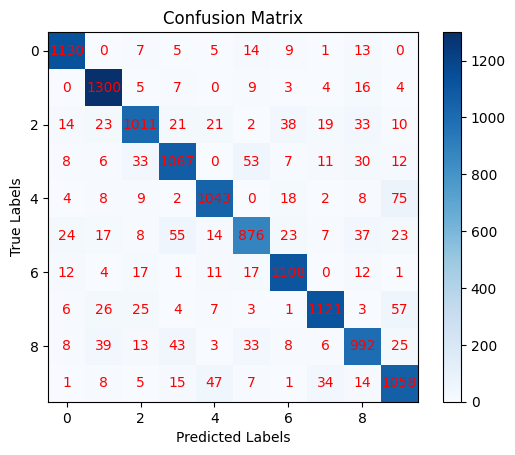

In [263]:
plt.imshow(confusion_matrix_multi, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(number_of_classes):
    for j in range(number_of_classes):
        plt.text(j, i, confusion_matrix_multi[i, j].item(), ha='center', va='center', color='red')

plt.show()

In [264]:
accuracy_per_class=confusion_matrix_multi.diagonal()/confusion_matrix_multi.sum(dim=1)
for i, accuracy in enumerate(accuracy_per_class):
    print(f'Accuracy for class {i}: {accuracy.item()*100:.2f}%')


Accuracy for class 0: 95.44%
Accuracy for class 1: 96.44%
Accuracy for class 2: 84.82%
Accuracy for class 3: 86.96%
Accuracy for class 4: 89.22%
Accuracy for class 5: 80.81%
Accuracy for class 6: 93.66%
Accuracy for class 7: 89.47%
Accuracy for class 8: 84.79%
Accuracy for class 9: 88.91%


In [312]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [313]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_sz, classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_sz, classes)

    def forward(self, x):
        out = self.linear(x)
        return out

In [314]:
model=SoftmaxRegression(input_sz=28*28, classes=10).to(device)
CEL=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [315]:
start_time=time.time()
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    total_loss=0
    for images,labels in training_loader:
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=CEL(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    loss_value=total_loss/len(training_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value:.4f}')

end_time=time.time()
softmax_built_in_time = end_time-start_time    

Epoch [1/10], Loss: 0.3743
Epoch [2/10], Loss: 0.3043
Epoch [3/10], Loss: 0.2932
Epoch [4/10], Loss: 0.2889
Epoch [5/10], Loss: 0.2826
Epoch [6/10], Loss: 0.2808
Epoch [7/10], Loss: 0.2785
Epoch [8/10], Loss: 0.2721
Epoch [9/10], Loss: 0.2702
Epoch [10/10], Loss: 0.2673


In [320]:
model.eval()
with torch.no_grad():
    test_output=model(data_test_tensor.to(device))
    test_predictions=torch.argmax(test_output,dim=1)
    true_labels=labels_test_tensor.to(device)
    SoftMax_built_in_accuracy=torch.mean((test_predictions.cpu()==labels_test_tensor).float())
    SoftMax_built_in_accuracy=SoftMax_built_in_accuracy.item()*100
print(f'Test Accuracy: {SoftMax_built_in_accuracy:.2f}%')

Test Accuracy: 90.96%


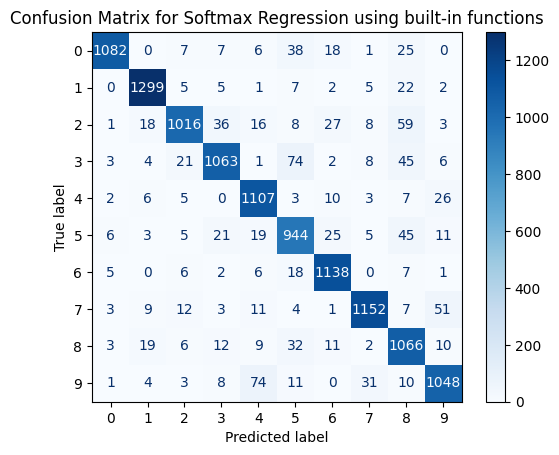

In [317]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix_nn=confusion_matrix(true_labels,test_predictions.cpu())

disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Softmax Regression using built-in functions')
plt.show()


## Neural Network

In [265]:
class ForwardNN(nn.Module):
    def __init__(self, input=784, hidden=None, output=10):
        super(ForwardNN,self).__init__()
        if hidden is None:
            hidden = [256, 18]
        layers=[]
        prev = input
        for hid in hidden:
            layers.append(nn.Linear(prev, hid))
            layers.append(nn.ReLU())
            prev = hid
        layers.append(nn.Linear(prev, output))
        self.network = nn.Sequential(*layers)
        for layer in layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    def forward(self,x):
        return self.network(x)

In [266]:
def calculate_accuracy(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [267]:
def train(model,epochs,lr,patience=5,training_loader=training_loader,validation_loader=validation_loader):
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    tl,vl = [],[]
    ta,va=[],[]
    batch_losses=[]
    pc=0
    best_val_loss=float('inf')
    for epoch in range(epochs):
        model.train()  
        curloss=0.0
        batch_loss=[]
        
        for inputs, labels in training_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            opt.zero_grad()
            loss.backward() #calculate grad  
            opt.step() # update weights 
            curloss += loss.item() * inputs.size(0)
            batch_loss.append(loss.item())
        batch_losses.append(batch_loss)
        epoch_train_loss =curloss/len(training_loader.dataset)
        
        #validation
        model.eval()
        valloss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valloss += loss.item() * inputs.size(0)
        epoch_val_loss = valloss / len(validation_loader.dataset)
        train_acc =calculate_accuracy(model, training_loader)
        val_acc =calculate_accuracy(model, validation_loader)
        tl.append(epoch_train_loss)
        vl.append(epoch_val_loss)
        ta.append(train_acc)
        va.append(val_acc) 
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            pc = 0
            best_model_state = model.state_dict()  # save best model weights
        else:
            pc += 1

        if pc >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # restore best model
            break
    return tl,vl,ta,va,batch_losses

In [274]:
model = ForwardNN(input=784, hidden=None, output=10)
tl,vl,ta,va,batch=train(model,30,0.01)

Epoch [1/30] Train Loss: 1.2326, Val Loss: 0.6198, Train Acc: 85.24%, Val Acc: 84.89%
Epoch [2/30] Train Loss: 0.4777, Val Loss: 0.4140, Train Acc: 89.09%, Val Acc: 89.06%
Epoch [3/30] Train Loss: 0.3668, Val Loss: 0.3530, Train Acc: 90.61%, Val Acc: 90.38%
Epoch [4/30] Train Loss: 0.3220, Val Loss: 0.3268, Train Acc: 91.33%, Val Acc: 90.79%
Epoch [5/30] Train Loss: 0.2943, Val Loss: 0.2994, Train Acc: 92.21%, Val Acc: 91.67%
Epoch [6/30] Train Loss: 0.2739, Val Loss: 0.2859, Train Acc: 92.46%, Val Acc: 91.89%
Epoch [7/30] Train Loss: 0.2569, Val Loss: 0.2688, Train Acc: 93.00%, Val Acc: 92.44%
Epoch [8/30] Train Loss: 0.2420, Val Loss: 0.2549, Train Acc: 93.46%, Val Acc: 92.77%
Epoch [9/30] Train Loss: 0.2288, Val Loss: 0.2451, Train Acc: 93.80%, Val Acc: 92.98%
Epoch [10/30] Train Loss: 0.2171, Val Loss: 0.2346, Train Acc: 94.11%, Val Acc: 93.24%
Epoch [11/30] Train Loss: 0.2057, Val Loss: 0.2278, Train Acc: 94.37%, Val Acc: 93.48%
Epoch [12/30] Train Loss: 0.1963, Val Loss: 0.2154, 

In [275]:
test_accNN = calculate_accuracy(model, testing_loader)
print(f"Final Test Accuracy: {test_accNN:.2f}%")

Final Test Accuracy: 96.03%


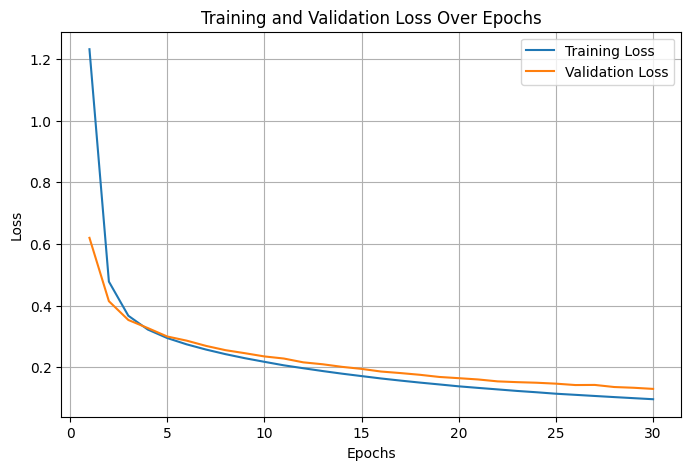

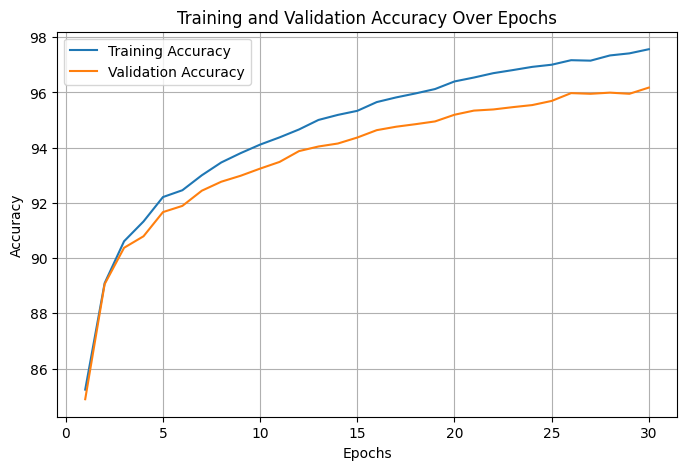

In [280]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

 Running training... Run 1/5
Epoch [1/30] Train Loss: 1.0450, Val Loss: 0.5225, Train Acc: 87.04%, Val Acc: 86.53%
Epoch [2/30] Train Loss: 0.4272, Val Loss: 0.3890, Train Acc: 89.54%, Val Acc: 89.18%
Epoch [3/30] Train Loss: 0.3462, Val Loss: 0.3388, Train Acc: 90.83%, Val Acc: 90.58%
Epoch [4/30] Train Loss: 0.3083, Val Loss: 0.3143, Train Acc: 91.58%, Val Acc: 91.16%
Epoch [5/30] Train Loss: 0.2831, Val Loss: 0.2884, Train Acc: 92.30%, Val Acc: 91.99%
Epoch [6/30] Train Loss: 0.2631, Val Loss: 0.2709, Train Acc: 92.84%, Val Acc: 92.41%
Epoch [7/30] Train Loss: 0.2458, Val Loss: 0.2570, Train Acc: 93.22%, Val Acc: 92.72%
Epoch [8/30] Train Loss: 0.2315, Val Loss: 0.2470, Train Acc: 93.64%, Val Acc: 93.04%
Epoch [9/30] Train Loss: 0.2184, Val Loss: 0.2331, Train Acc: 94.07%, Val Acc: 93.40%
Epoch [10/30] Train Loss: 0.2069, Val Loss: 0.2225, Train Acc: 94.38%, Val Acc: 93.48%
Epoch [11/30] Train Loss: 0.1965, Val Loss: 0.2189, Train Acc: 94.44%, Val Acc: 93.66%
Epoch [12/30] Train Los

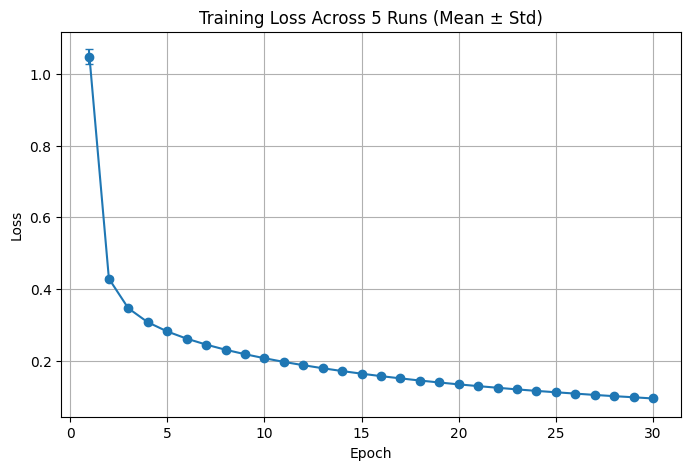

In [281]:
runs = 5
all_train_losses = []  
for r in range(runs):
    print(f" Running training... Run {r+1}/{runs}")
    model = ForwardNN(hidden=[256,128])
    train_losses, val_losses, train_accs, val_accs, _ = train(model, epochs=30,lr=0.01)
    all_train_losses.append(train_losses)
all_train_losses = np.array(all_train_losses)
train_mean = np.mean(all_train_losses, axis=0)
train_std  = np.std(all_train_losses, axis=0)
epochs_range = range(1, len(train_mean)+1)
plt.figure(figsize=(8,5))
plt.errorbar(epochs_range, train_mean, yerr=train_std, fmt='-o', capsize=3)
plt.title("Training Loss Across 5 Runs (Mean ± Std)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


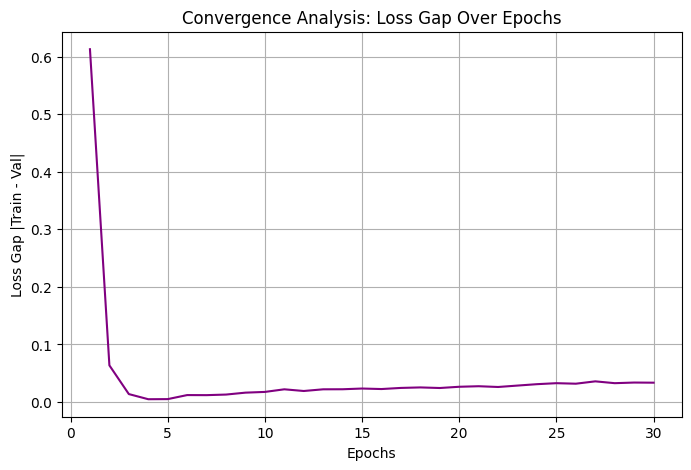

In [282]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

## Part C: Comprehensive Analysis

# C1. Hyperparameter Analysis

## Learning Rate Analysis

In [283]:
# learning rate analysis
learning_rates = [0.001, 0.01, 0.1, 1.0]
results_lr = {}

In [284]:
for lr in learning_rates:
    print(f"\n==== Training with Learning Rate = {lr} ====")
    model = ForwardNN()
    train_losses, val_losses, train_accs, val_accs,bl = train(model,50,lr)
    results_lr[lr] = (train_losses, val_losses, train_accs, val_accs)


==== Training with Learning Rate = 0.001 ====
Epoch [1/50] Train Loss: 2.2100, Val Loss: 2.0870, Train Acc: 38.06%, Val Acc: 37.83%
Epoch [2/50] Train Loss: 1.9696, Val Loss: 1.8577, Train Acc: 49.24%, Val Acc: 48.55%
Epoch [3/50] Train Loss: 1.7521, Val Loss: 1.6497, Train Acc: 55.23%, Val Acc: 54.61%
Epoch [4/50] Train Loss: 1.5520, Val Loss: 1.4554, Train Acc: 63.15%, Val Acc: 62.80%
Epoch [5/50] Train Loss: 1.3577, Val Loss: 1.2629, Train Acc: 70.24%, Val Acc: 70.19%
Epoch [6/50] Train Loss: 1.1680, Val Loss: 1.0821, Train Acc: 76.97%, Val Acc: 76.71%
Epoch [7/50] Train Loss: 0.9986, Val Loss: 0.9290, Train Acc: 80.34%, Val Acc: 80.03%
Epoch [8/50] Train Loss: 0.8599, Val Loss: 0.8079, Train Acc: 82.54%, Val Acc: 82.22%
Epoch [9/50] Train Loss: 0.7539, Val Loss: 0.7188, Train Acc: 83.96%, Val Acc: 83.49%
Epoch [10/50] Train Loss: 0.6762, Val Loss: 0.6529, Train Acc: 85.01%, Val Acc: 84.62%
Epoch [11/50] Train Loss: 0.6183, Val Loss: 0.6035, Train Acc: 85.72%, Val Acc: 85.30%
Epoch

In [285]:
best_lr = None
best_acc = -1

for lr, result in results_lr.items():
    _, _, _, val_accs = result
    final_acc = val_accs[-1]  # last validation accuracy
    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = lr
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_acc:.2f}%")


Best Learning Rate: 0.1
Best Validation Accuracy: 97.71%


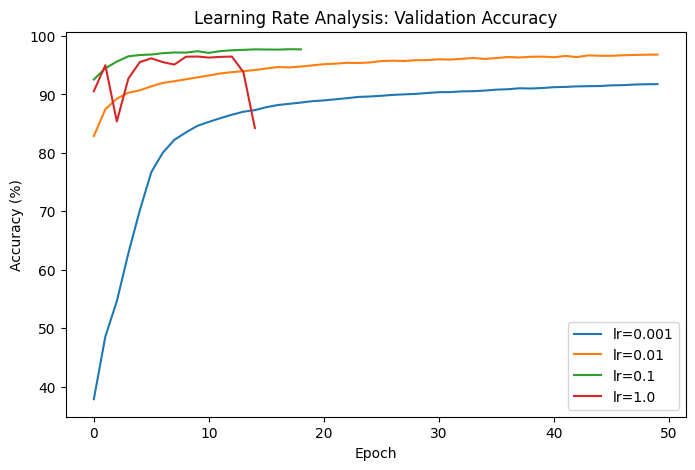

In [286]:
plt.figure(figsize=(8, 5))
for lr, (_, _, _, val_accs) in results_lr.items():
    plt.plot(val_accs, label=f"lr={lr}")
plt.title("Learning Rate Analysis: Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

##  Analyze convergence speed and stability 
R = 0.001:
Learns very slowly but is stable.

LR = 0.01:
Fast learning and very stable — best performance.

LR = 0.1:
Learns very fast but has small ups and downs.

LR = 1.0:
Very unstable — accuracy jumps a lot and does not settle.


# Batch Size Analysis


==== Training with Batch Size = 16 ====
Epoch [1/30] Train Loss: 0.5992, Val Loss: 0.3302, Train Acc: 91.11%, Val Acc: 90.32%
Epoch [2/30] Train Loss: 0.2779, Val Loss: 0.2566, Train Acc: 93.31%, Val Acc: 92.44%
Epoch [3/30] Train Loss: 0.2194, Val Loss: 0.2193, Train Acc: 94.59%, Val Acc: 93.59%
Epoch [4/30] Train Loss: 0.1821, Val Loss: 0.1990, Train Acc: 95.07%, Val Acc: 94.01%
Epoch [5/30] Train Loss: 0.1565, Val Loss: 0.1692, Train Acc: 96.12%, Val Acc: 94.94%
Epoch [6/30] Train Loss: 0.1361, Val Loss: 0.1555, Train Acc: 96.58%, Val Acc: 95.34%
Epoch [7/30] Train Loss: 0.1191, Val Loss: 0.1452, Train Acc: 97.09%, Val Acc: 95.69%
Epoch [8/30] Train Loss: 0.1056, Val Loss: 0.1314, Train Acc: 97.54%, Val Acc: 96.15%
Epoch [9/30] Train Loss: 0.0941, Val Loss: 0.1288, Train Acc: 97.63%, Val Acc: 96.04%
Epoch [10/30] Train Loss: 0.0844, Val Loss: 0.1188, Train Acc: 98.05%, Val Acc: 96.57%
Epoch [11/30] Train Loss: 0.0755, Val Loss: 0.1134, Train Acc: 98.30%, Val Acc: 96.62%
Epoch [12/3

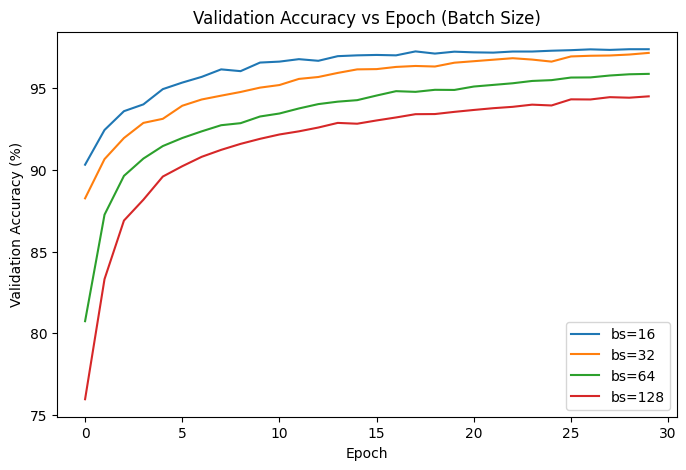

In [287]:
batch_sizes = [16, 32, 64, 128]
results_bs = []
plt.figure(figsize=(8, 5))
for bs in batch_sizes:
    print(f"\n==== Training with Batch Size = {bs} ====")
    train_loader = DataLoader(trainig_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
    model = ForwardNN()
    start_time = time.time()
    train_losses, val_losses, train_accs, val_accs ,bl= train(
        model,30,0.01,5,train_loader,val_loader
    )
    elapsed = time.time() - start_time
    results_bs.append((bs, val_accs[-1], round(elapsed, 1)))
    plt.plot(val_accs, label=f'bs={bs}')

plt.title('Validation Accuracy vs Epoch (Batch Size)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

In [288]:
best_bs = None
best_acc = -1
best_time = None

for bs, acc, t in results_bs:
    if acc > best_acc:
        best_acc = acc
        best_bs = bs
        best_time = t

In [289]:
# create a summary table
batch_results_df = pd.DataFrame(
    results_bs, columns=['Batch Size', 'Final Val Accuracy (%)', 'Training Time (s)']   
)

print("\nBatch Size Comparison:")
print(batch_results_df)


Batch Size Comparison:
   Batch Size  Final Val Accuracy (%)  Training Time (s)
0          16               97.383333              204.0
1          32               97.158333              114.5
2          64               95.875000               90.9
3         128               94.500000               84.7


 # Analyze effect on gradient noise 
Batch Size = 16:
Highest gradient noise — updates jump a lot.
Slower but can generalize better.

Batch Size = 32:
Moderate noise — good balance between stability and learning.

Batch Size = 64:
Low noise — smoother training, faster convergence.

Batch Size = 128:
Very low noise — stable but may get stuck and give slightly worse accuracy.

## Architecture Analysis

In [290]:
number_of_layers = [2,3,4,5]
neurons = [64,128,256,512]
architectures=[]
for layers in number_of_layers:
    for neuron in neurons:
        architectures.append([neuron]*layers)
architectures


[[64, 64],
 [128, 128],
 [256, 256],
 [512, 512],
 [64, 64, 64],
 [128, 128, 128],
 [256, 256, 256],
 [512, 512, 512],
 [64, 64, 64, 64],
 [128, 128, 128, 128],
 [256, 256, 256, 256],
 [512, 512, 512, 512],
 [64, 64, 64, 64, 64],
 [128, 128, 128, 128, 128],
 [256, 256, 256, 256, 256],
 [512, 512, 512, 512, 512]]

In [291]:
results = []
for arch in architectures:
    print(f"\nTraining architecture: {arch}")
    model = ForwardNN(hidden = arch)
    start_time = time.time()
    train_losses, val_losses, train_accs, val_accs,bl = train(model,30,0.01)
    elapsed =round(time.time() - start_time,2)
    results.append({
        "Architecture":arch,
        "Layers": len(arch),
        "Neurons": arch[0],
        "Best Val Accuracy": round(max(val_accs), 2),
        "Time (s)": elapsed
    })



Training architecture: [64, 64]
Epoch [1/30] Train Loss: 1.2035, Val Loss: 0.6158, Train Acc: 84.36%, Val Acc: 83.56%
Epoch [2/30] Train Loss: 0.4906, Val Loss: 0.4318, Train Acc: 88.44%, Val Acc: 88.03%
Epoch [3/30] Train Loss: 0.3833, Val Loss: 0.3731, Train Acc: 89.99%, Val Acc: 89.55%
Epoch [4/30] Train Loss: 0.3387, Val Loss: 0.3419, Train Acc: 90.76%, Val Acc: 90.56%
Epoch [5/30] Train Loss: 0.3117, Val Loss: 0.3179, Train Acc: 91.66%, Val Acc: 91.14%
Epoch [6/30] Train Loss: 0.2916, Val Loss: 0.3033, Train Acc: 91.96%, Val Acc: 91.32%
Epoch [7/30] Train Loss: 0.2757, Val Loss: 0.2869, Train Acc: 92.31%, Val Acc: 91.67%
Epoch [8/30] Train Loss: 0.2617, Val Loss: 0.2735, Train Acc: 92.75%, Val Acc: 92.20%
Epoch [9/30] Train Loss: 0.2495, Val Loss: 0.2636, Train Acc: 93.17%, Val Acc: 92.56%
Epoch [10/30] Train Loss: 0.2385, Val Loss: 0.2544, Train Acc: 93.40%, Val Acc: 92.75%
Epoch [11/30] Train Loss: 0.2285, Val Loss: 0.2446, Train Acc: 93.73%, Val Acc: 93.09%
Epoch [12/30] Train

In [292]:
df = pd.DataFrame(results)
print(df)

                 Architecture  Layers  Neurons  Best Val Accuracy  Time (s)
0                    [64, 64]       2       64              95.50     85.06
1                  [128, 128]       2      128              95.74     93.37
2                  [256, 256]       2      256              96.06    116.05
3                  [512, 512]       2      512              96.34    174.74
4                [64, 64, 64]       3       64              95.88     89.29
5             [128, 128, 128]       3      128              96.54    102.44
6             [256, 256, 256]       3      256              96.83    132.06
7             [512, 512, 512]       3      512              97.02    223.30
8            [64, 64, 64, 64]       4       64              96.29     99.07
9        [128, 128, 128, 128]       4      128              96.60    104.18
10       [256, 256, 256, 256]       4      256              97.07    136.08
11       [512, 512, 512, 512]       4      512              97.17    269.72
12       [64

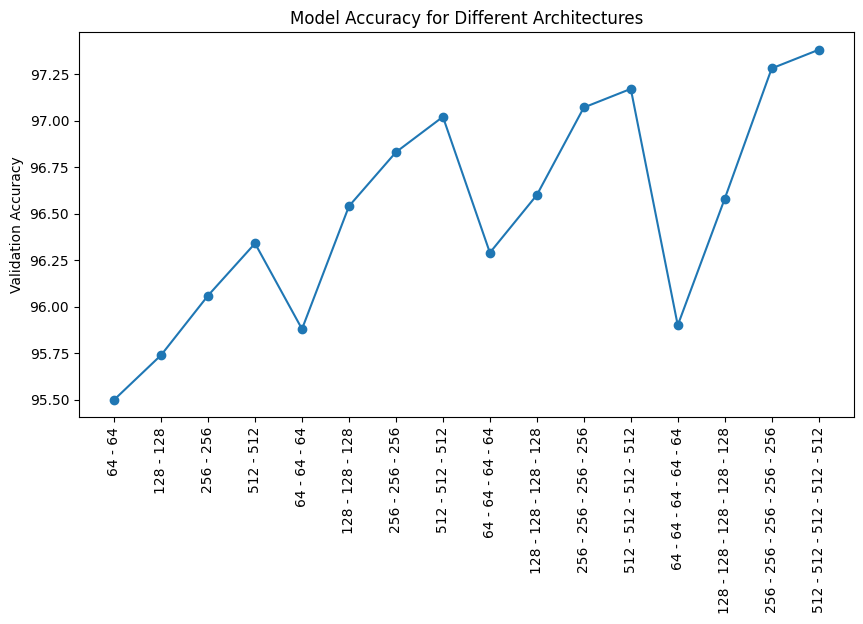

[512, 512, 512, 512, 512]

In [293]:
df["Architecture_str"] = df["Architecture"].apply(lambda x: " - ".join(map(str, x)))
plt.figure(figsize=(10,5))
plt.plot(df["Architecture_str"], df["Best Val Accuracy"], marker="o")
plt.xticks(rotation=90)
plt.ylabel("Validation Accuracy")
plt.title("Model Accuracy for Different Architectures")
plt.show()
best = df.loc[df["Best Val Accuracy"].idxmax()]
best_arch = best["Architecture"]
best_arch


## Comparative Analysis

In [322]:
comparison_data = {
    "Model": ["Logistic Regression", "Softmax Regression","Softmax Builtin ","Best Neural Network"],
    "Test Accuracy (%)": [logistic_regression_acc, softmax_accuracy,SoftMax_built_in_accuracy ,max(df["Best Val Accuracy"])],
    "Training Time (s)": [logistic_regression_time, softmax_time, softmax_built_in_time,df["Time (s)"].min()]
}

In [323]:
comparison_df = pd.DataFrame(comparison_data)
print("\n=== Model Comparison Summary ===")
print(comparison_df)


=== Model Comparison Summary ===
                 Model  Test Accuracy (%)  Training Time (s)
0  Logistic Regression          99.842024           8.798423
1   Softmax Regression          89.216667          23.090686
2     Softmax Builtin           90.958333          14.429577
3  Best Neural Network          97.380000          78.440000


Models

Logistic Regression: Basic model, works for simple data  Small/simple dataset

Softmax Regression: Like logistic but for multi-class   Small/simple dataset

Neural Network: More advanced, learns complex patterns    Large/complex data


Logistic and softmax regression are simple and fast but limited.
Neural networks take longer to train but give the highest accuracy, especially on complex data.

## Best Model Evaluation

In [296]:
best_model = ForwardNN(input=784, hidden=best_arch, output=10)
train_loader = DataLoader(trainig_dataset, batch_size=best_bs, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=best_bs, shuffle=False)
train(best_model,30,best_lr,5,train_loader,val_loader)
test_accNN = calculate_accuracy(best_model, testing_loader)
print(f"Final Test Accuracy: {test_accNN:.2f}%")

Epoch [1/30] Train Loss: 0.3249, Val Loss: 0.1540, Train Acc: 96.17%, Val Acc: 95.11%
Epoch [2/30] Train Loss: 0.1227, Val Loss: 0.1260, Train Acc: 97.49%, Val Acc: 96.08%
Epoch [3/30] Train Loss: 0.0851, Val Loss: 0.1006, Train Acc: 98.49%, Val Acc: 97.01%
Epoch [4/30] Train Loss: 0.0627, Val Loss: 0.1291, Train Acc: 98.29%, Val Acc: 96.62%
Epoch [5/30] Train Loss: 0.0469, Val Loss: 0.1227, Train Acc: 98.32%, Val Acc: 96.51%
Epoch [6/30] Train Loss: 0.0377, Val Loss: 0.1227, Train Acc: 98.70%, Val Acc: 96.91%
Epoch [7/30] Train Loss: 0.0309, Val Loss: 0.0955, Train Acc: 99.31%, Val Acc: 97.38%
Epoch [8/30] Train Loss: 0.0231, Val Loss: 0.1081, Train Acc: 99.51%, Val Acc: 97.42%
Epoch [9/30] Train Loss: 0.0216, Val Loss: 0.0951, Train Acc: 99.56%, Val Acc: 97.65%
Epoch [10/30] Train Loss: 0.0151, Val Loss: 0.1043, Train Acc: 99.65%, Val Acc: 97.51%
Epoch [11/30] Train Loss: 0.0175, Val Loss: 0.1034, Train Acc: 99.63%, Val Acc: 97.69%
Epoch [12/30] Train Loss: 0.0130, Val Loss: 0.1148, 

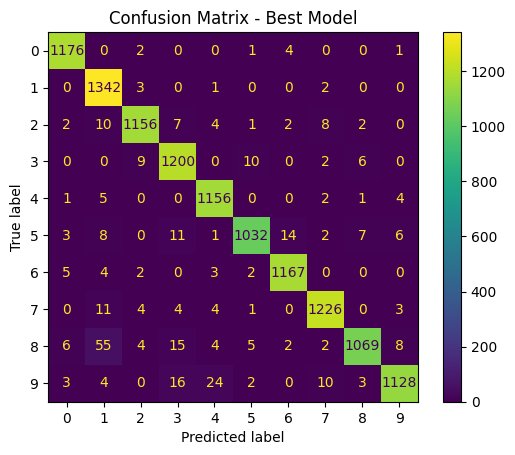

In [297]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
best_model.eval()
with torch.no_grad():
    for x, y in testing_loader:
        preds = best_model(x)
        preds = preds.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_labels.extend(y.cpu())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - Best Model")
plt.show()

## Miss Classifcation

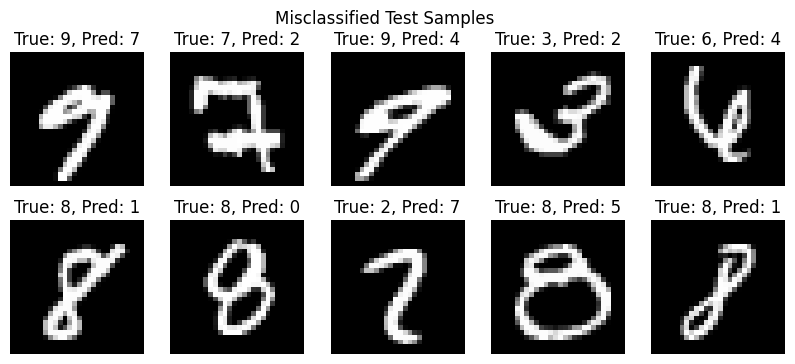

In [298]:
incorrect_imgs = []
incorrect_pred = []
incorrect_true = []

best_model.eval()
with torch.no_grad():
    for x, y in testing_loader:
        preds = best_model(x).argmax(dim=1)
        for img, p, t in zip(x, preds, y):
            if p != t:
                incorrect_imgs.append(img)
                incorrect_pred.append(p.item())
                incorrect_true.append(t.item())
            if len(incorrect_imgs) == 10:  
                break
        if len(incorrect_imgs) == 10:
            break

fig, axes = plt.subplots(2,5, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(incorrect_imgs[i].reshape(28,28), cmap="gray")
    ax.set_title(f"True: {incorrect_true[i]}, Pred: {incorrect_pred[i]}")
    ax.axis('off')
plt.suptitle("Misclassified Test Samples")
plt.show()


True 5 → Pred 7: The 5 has a slanted or open top, which looks similar to a 7.

True 3 → Pred 5 / 6: Some 3s are written with a closed top loop, making them resemble 5 or 6.

True 2 → Pred 6 / 7 / 8: The 2s have loops or curves that make them visually similar to 6, 7, or 8.

Insight: Even humans sometimes misread poorly written digits; the nueral network struggles with unusual handwriting

#Insights & Limitations

Misclassification Observations:

Most errors happened on similar looking classes

Some digits/images are badly written/noisy

Limitations:

Requires more training time than logistic/softmax regression

## CNN

In [299]:
class CNN(nn.Module):
    def __init__(self,dropout=0.0,batch=False):
        super(CNN, self).__init__()
        layers1 = [
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), 
        ]
        if batch:
            layers1.append(nn.BatchNorm2d(16))
        layers1 += [
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        ]
        self.cn1 = nn.Sequential(*layers1)
        layers2 = [
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        ]
        if batch:
            layers2.append(nn.BatchNorm2d(32))
        layers2 += [
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        ]
        self.cn2 = nn.Sequential(*layers2)

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x=x.view(-1,1,28,28)
        x = self.cn1(x)
        x = self.cn2(x)
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

In [300]:
modelCNN= CNN()
tl,vl,ta,va,_=train(modelCNN,30,0.01)

Epoch [1/30] Train Loss: 1.5772, Val Loss: 0.5935, Train Acc: 80.30%, Val Acc: 80.40%
Epoch [2/30] Train Loss: 0.3675, Val Loss: 0.3086, Train Acc: 90.82%, Val Acc: 90.32%
Epoch [3/30] Train Loss: 0.2438, Val Loss: 0.2062, Train Acc: 94.03%, Val Acc: 93.85%
Epoch [4/30] Train Loss: 0.1849, Val Loss: 0.1853, Train Acc: 94.22%, Val Acc: 93.98%
Epoch [5/30] Train Loss: 0.1490, Val Loss: 0.1815, Train Acc: 94.67%, Val Acc: 94.28%
Epoch [6/30] Train Loss: 0.1252, Val Loss: 0.1224, Train Acc: 96.50%, Val Acc: 96.08%
Epoch [7/30] Train Loss: 0.1080, Val Loss: 0.1038, Train Acc: 97.13%, Val Acc: 96.82%
Epoch [8/30] Train Loss: 0.0964, Val Loss: 0.0972, Train Acc: 97.21%, Val Acc: 96.90%
Epoch [9/30] Train Loss: 0.0864, Val Loss: 0.0885, Train Acc: 97.52%, Val Acc: 97.15%
Epoch [10/30] Train Loss: 0.0801, Val Loss: 0.0898, Train Acc: 97.57%, Val Acc: 97.09%
Epoch [11/30] Train Loss: 0.0739, Val Loss: 0.0889, Train Acc: 97.60%, Val Acc: 97.29%
Epoch [12/30] Train Loss: 0.0684, Val Loss: 0.0722, 

In [301]:
test_acc = calculate_accuracy(modelCNN, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 98.08%


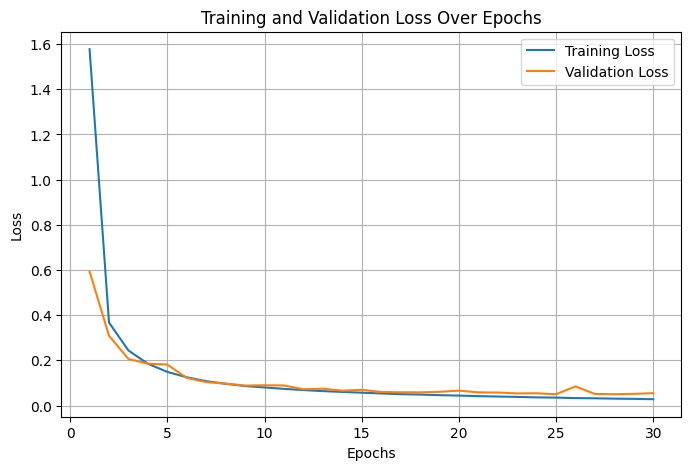

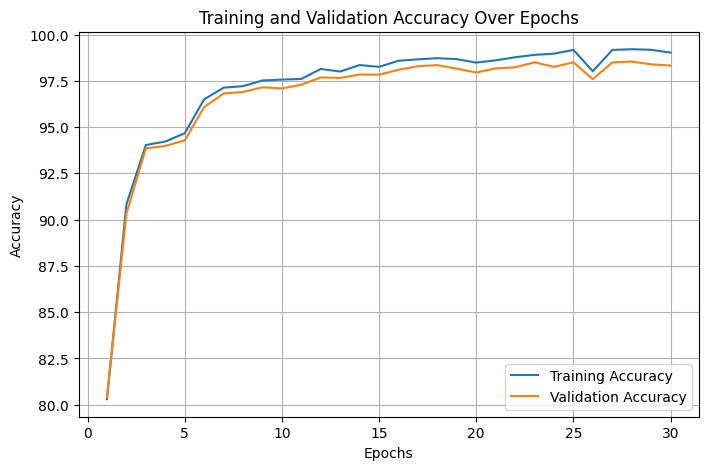

In [302]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

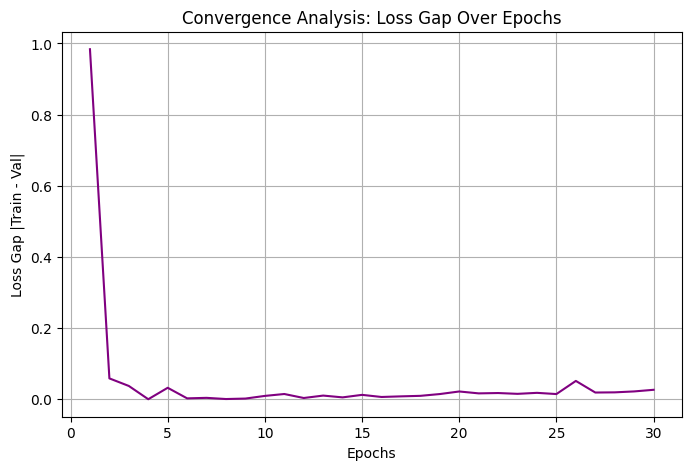

In [303]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

# Comparison
NN 96-97 %
CNN 98-99%
Convolutional Neural Networks preserve the 2D image structure and learn spatial features
Fully-connected networks flatten the image and lose spatial relationships, making them less efficient for vision tasks.

## Dropuout 

In [304]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results = {}

for rate in dropout_rates:
    print(f"\n🔹 Training with Dropout rate = {rate}")
    model = CNN(dropout=rate)
    tl, vl, ta, va, _ = train(model, epochs=30, lr=0.01)
    results[rate] = {"train_loss": tl, "val_loss": vl, "train_acc": ta, "val_acc": va}



🔹 Training with Dropout rate = 0.1
Epoch [1/30] Train Loss: 1.8258, Val Loss: 0.6284, Train Acc: 80.38%, Val Acc: 80.67%
Epoch [2/30] Train Loss: 0.4400, Val Loss: 0.4202, Train Acc: 86.10%, Val Acc: 85.83%
Epoch [3/30] Train Loss: 0.2808, Val Loss: 0.2352, Train Acc: 92.90%, Val Acc: 92.72%
Epoch [4/30] Train Loss: 0.2100, Val Loss: 0.1672, Train Acc: 95.21%, Val Acc: 94.81%
Epoch [5/30] Train Loss: 0.1662, Val Loss: 0.1392, Train Acc: 96.03%, Val Acc: 95.78%
Epoch [6/30] Train Loss: 0.1397, Val Loss: 0.1142, Train Acc: 96.68%, Val Acc: 96.40%
Epoch [7/30] Train Loss: 0.1195, Val Loss: 0.1069, Train Acc: 96.97%, Val Acc: 96.74%
Epoch [8/30] Train Loss: 0.1073, Val Loss: 0.0987, Train Acc: 97.22%, Val Acc: 97.01%
Epoch [9/30] Train Loss: 0.0974, Val Loss: 0.0850, Train Acc: 97.61%, Val Acc: 97.43%
Epoch [10/30] Train Loss: 0.0888, Val Loss: 0.0843, Train Acc: 97.68%, Val Acc: 97.31%
Epoch [11/30] Train Loss: 0.0821, Val Loss: 0.0753, Train Acc: 97.90%, Val Acc: 97.62%
Epoch [12/30] Tr

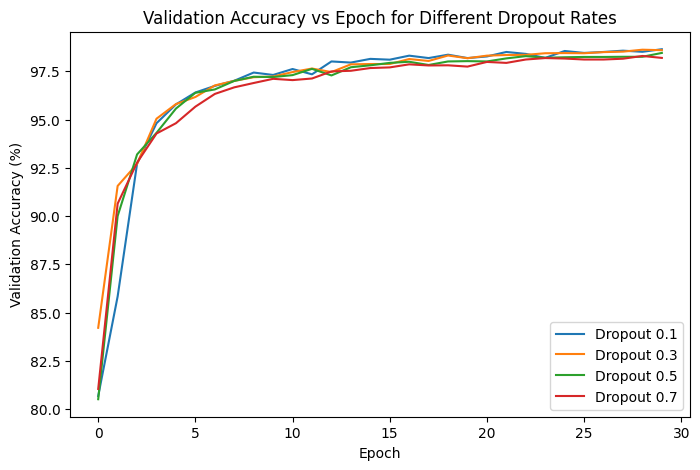

In [305]:
plt.figure(figsize=(8,5))
for rate in dropout_rates:
    plt.plot(results[rate]["val_acc"], label=f"Dropout {rate}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Epoch for Different Dropout Rates")
plt.legend()
plt.show()

In [306]:
best_rate = max(dropout_rates, key=lambda r: max(results[r]["val_acc"]))
best_val_acc = max(results[best_rate]["val_acc"])
print(f"\n Best Dropout Rate: {best_rate} (Validation Accuracy: {best_val_acc:.2f}%)")


 Best Dropout Rate: 0.1 (Validation Accuracy: 98.64%)


## analysis
All dropout rates eventually converge to high accuracy arround 98%.

Early epochs show a gap: high dropout (0.7) learns slower moderate dropout (0.3–0.5) rises faster.

The best rate (0.3) balances learning speed and generalization.

In [307]:
#Batch Normalization

In [308]:
configs = [
    {"use_batchnorm": False, "dropout_rate": 0.0, "label": "No BN, No Dropout"},
    {"use_batchnorm": True,  "dropout_rate": 0.0, "label": "BN only"},
    {"use_batchnorm": False, "dropout_rate": best_rate, "label": f"Dropout {best_rate} only"},
    {"use_batchnorm": True,  "dropout_rate": best_rate, "label": f"BN + Dropout {best_rate}"},
]

results = {}

for cfg in configs:
    print(f"\n🔹 Training: {cfg['label']}")
    model = CNN(
        dropout=cfg["dropout_rate"], 
        batch=cfg["use_batchnorm"]
    )
    tl, vl, ta,va,_ = train(model, epochs=30, lr=0.01, training_loader=training_loader, validation_loader=validation_loader)
    results[cfg['label']] = {"train_loss": tl, "val_loss": vl, "val_acc": va}



🔹 Training: No BN, No Dropout
Epoch [1/30] Train Loss: 1.6090, Val Loss: 0.6855, Train Acc: 77.96%, Val Acc: 77.68%
Epoch [2/30] Train Loss: 0.3987, Val Loss: 0.3026, Train Acc: 91.08%, Val Acc: 90.83%
Epoch [3/30] Train Loss: 0.2675, Val Loss: 0.2205, Train Acc: 93.64%, Val Acc: 93.34%
Epoch [4/30] Train Loss: 0.2012, Val Loss: 0.1806, Train Acc: 94.92%, Val Acc: 94.54%
Epoch [5/30] Train Loss: 0.1619, Val Loss: 0.1554, Train Acc: 95.57%, Val Acc: 95.32%
Epoch [6/30] Train Loss: 0.1347, Val Loss: 0.1258, Train Acc: 96.44%, Val Acc: 96.12%
Epoch [7/30] Train Loss: 0.1163, Val Loss: 0.1396, Train Acc: 95.87%, Val Acc: 95.53%
Epoch [8/30] Train Loss: 0.1022, Val Loss: 0.1175, Train Acc: 96.67%, Val Acc: 96.20%
Epoch [9/30] Train Loss: 0.0921, Val Loss: 0.1023, Train Acc: 97.13%, Val Acc: 96.55%
Epoch [10/30] Train Loss: 0.0835, Val Loss: 0.0861, Train Acc: 97.72%, Val Acc: 97.37%
Epoch [11/30] Train Loss: 0.0768, Val Loss: 0.0947, Train Acc: 97.37%, Val Acc: 96.97%
Epoch [12/30] Train L

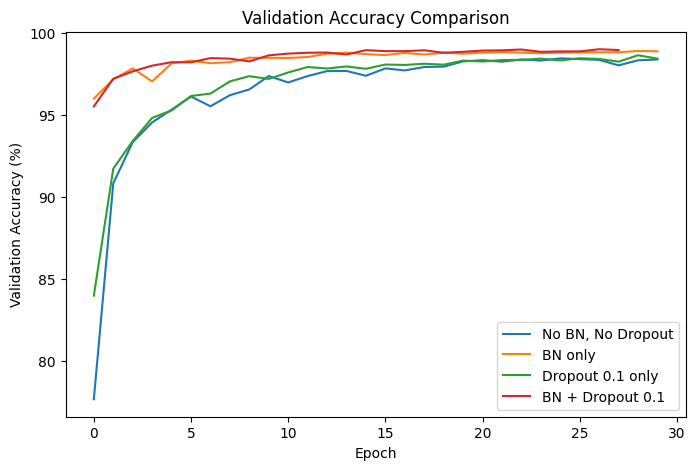

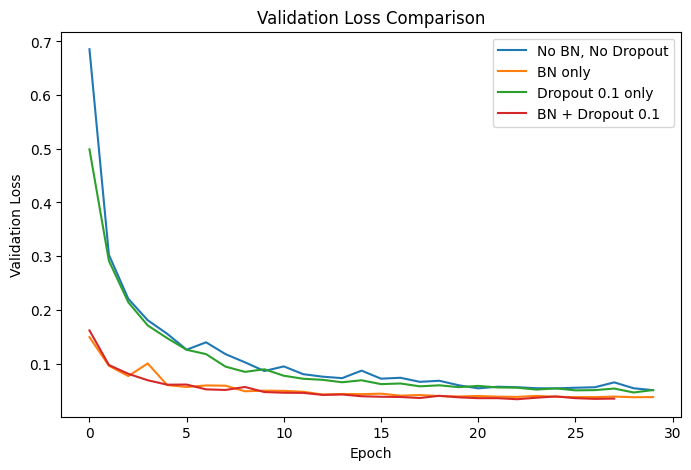

In [309]:
plt.figure(figsize=(8,5))
for label in results.keys():
    plt.plot(results[label]["val_acc"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for label in results.keys():
    plt.plot(results[label]["val_loss"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


No BN, No Dropout (blue):

The baseline model shows steady improvement but slower convergence.

It reaches around 97–98% accuracy, indicating decent learning but some instability.

Slight fluctuations suggest mild overfitting or less stable gradients.

BN only (orange):

Achieves the fastest convergence — validation accuracy jumps above 95% within a few epochs.

Maintains consistently high accuracy (~98.7%) with smoother curves.

Confirms that Batch Normalization improves training stability and convergence speed by standardizing activations.

Dropout 0.3 only (green):

Learning starts slower due to the regularization effect.

Final accuracy slightly below BN-only but still strong (~98.4%).

Indicates Dropout helps generalization, though it slows early learning.

BN + Dropout 0.3 (red):

Combines the benefits: fast convergence (from BN) and good generalization (from Dropout).

Achieves the most stable and highest validation accuracy (~98.8–99%).

This configuration minimizes overfitting and provides robust performance.

# Final test with the best regulization

In [310]:
FinalModel = CNN(best_rate,True)
tl, vl, ta,va,_ = train(FinalModel, epochs=30, lr=0.01)

Epoch [1/30] Train Loss: 0.4380, Val Loss: 0.1541, Train Acc: 96.16%, Val Acc: 95.92%
Epoch [2/30] Train Loss: 0.1256, Val Loss: 0.1315, Train Acc: 96.26%, Val Acc: 96.07%
Epoch [3/30] Train Loss: 0.0905, Val Loss: 0.0799, Train Acc: 98.06%, Val Acc: 97.78%
Epoch [4/30] Train Loss: 0.0738, Val Loss: 0.0808, Train Acc: 97.96%, Val Acc: 97.65%
Epoch [5/30] Train Loss: 0.0625, Val Loss: 0.0690, Train Acc: 98.39%, Val Acc: 97.92%
Epoch [6/30] Train Loss: 0.0548, Val Loss: 0.0533, Train Acc: 98.81%, Val Acc: 98.47%
Epoch [7/30] Train Loss: 0.0494, Val Loss: 0.0546, Train Acc: 98.77%, Val Acc: 98.34%
Epoch [8/30] Train Loss: 0.0445, Val Loss: 0.0515, Train Acc: 98.95%, Val Acc: 98.54%
Epoch [9/30] Train Loss: 0.0414, Val Loss: 0.0480, Train Acc: 99.11%, Val Acc: 98.62%
Epoch [10/30] Train Loss: 0.0379, Val Loss: 0.0490, Train Acc: 99.10%, Val Acc: 98.56%
Epoch [11/30] Train Loss: 0.0348, Val Loss: 0.0451, Train Acc: 99.28%, Val Acc: 98.67%
Epoch [12/30] Train Loss: 0.0316, Val Loss: 0.0427, 

In [311]:
test_acc = calculate_accuracy(FinalModel, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 98.73%
